In [1]:
from __future__ import division, print_function

import cPickle as pickle

import numpy as np
from scipy.spatial import cKDTree
from scipy import stats

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import SkyCoord, Distance
from astropy.coordinates.angles import rotation_matrix

from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.cosmology import WMAP9

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import rcParams, animation
from mpl_toolkits.mplot3d import Axes3D

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

In [3]:
def save_pub_figure(basename, figdir='figures', fig=None):
    import os
    if fig is None:
        fig = plt.gcf()
    plt.savefig(os.path.join(figdir, basename+'.pdf'))
    plt.savefig(os.path.join(figdir, basename+'.png'))

# Load Data 

In [4]:
#distances from MCMC
npz = np.load('PiscAB_distances_2015_07_23.npz')
PiscA_dist = Distance(npz['piscA_dist_Mpc'], u.Mpc)
PiscB_dist = Distance(npz['piscB_dist_Mpc'], u.Mpc)

PiscA = SkyCoord('00h14m46s', '+10d48m47.01s', distance=Distance(np.percentile(PiscA_dist, [50, 16, 84]), u.Mpc))
PiscB = SkyCoord('01h19m11.7s', '+11d7m18.22s', distance=Distance(np.percentile(PiscB_dist, [50, 16, 84]), u.Mpc))

PiscA_MHI = [2.8, .2] *u.solMass*1e5 * u.Mpc**-2 # value, unc
PiscB_MHI = [3.8, .4] *u.solMass*1e5 * u.Mpc**-2 # value, unc

In [5]:
#structural parameters - need to define the SersicModel to be able to un-pickle
with open('strucparams_chains_2015_07_22.pckl') as f:
    struc_param_dct = pickle.load(f)

def get_struc_param(chainnm, paramnm):
    sp = struc_param_dct['chains'+chainnm]
    idx = struc_param_dct['param_names'].index(paramnm)
    return sp[:, :, idx].ravel()

def minify_chains(*chains):
    chains = [np.array(chain, copy=False).ravel() for chain in chains]
    minchain = np.min([chain.size for chain in chains])
    return [chain[:minchain] for chain in chains]

In [6]:
ml = ascii.read('masterlist.csv')

In [7]:
m31 = SkyCoord(SkyCoord.from_name('M31'), distance=750*u.kpc)

# Spatial 

In [ ]:
%matplotlib nbagg

In [8]:
msk = (ml['distance']>0)&(ml['distance']<15)
mml = ml[msk]
mlsc = SkyCoord(mml['RA']*u.deg, mml['Dec']*u.deg, distance=Distance(mml['distance'], u.Mpc))
mlcart = mlsc.cartesian
mlgcart = mlsc.galactic.cartesian
Kabsm = mml['K'] - mlsc.distance.distmod

In [9]:
twomasslimit = 13.5*u.mag-Distance(2**0.5*10*u.Mpc).distmod
mlgcomplmsk = Kabsm < twomasslimit.value
twomasslimit

<Quantity -17.252574989159953 mag>

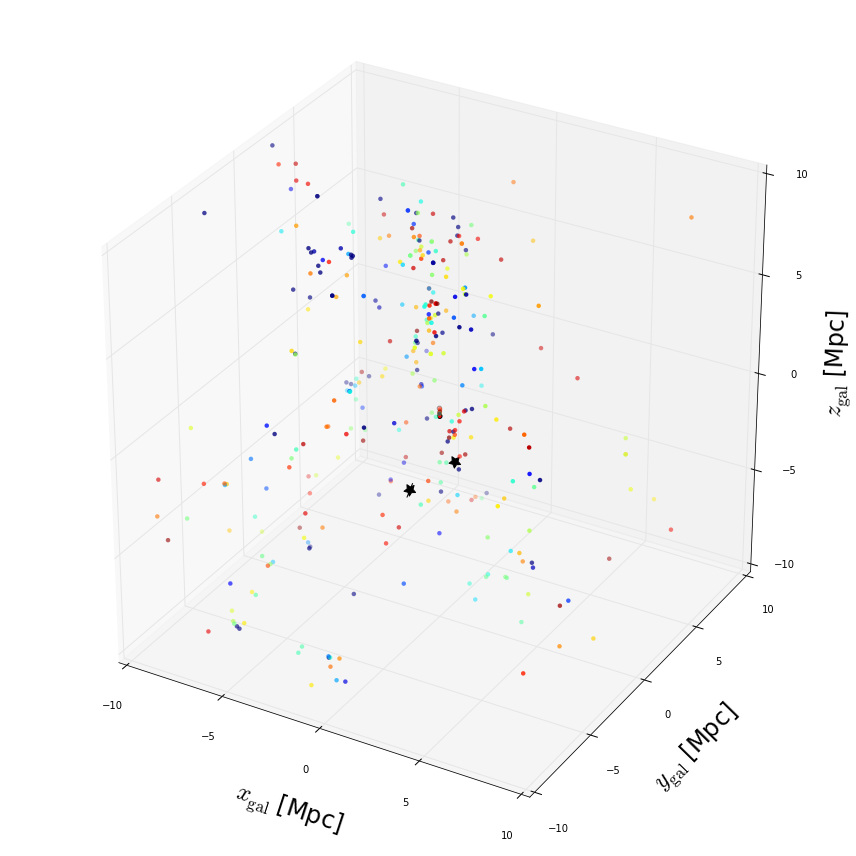

In [10]:
fig = plt.figure(figsize=(12,12))
fig.patch.set_alpha(1)
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0,bottom=0,top=1,right=1, wspace=0, hspace=0)

msk10box = (-10<mlgcart.x.value)&(mlgcart.x.value<10)&(-10<mlgcart.y.value)&(mlgcart.y.value<10)&(-10<mlgcart.z.value)&(mlgcart.z.value<10)
lgscat = ax.scatter3D(mlgcart.x[msk10box&mlgcomplmsk], mlgcart.y[msk10box&mlgcomplmsk], mlgcart.z[msk10box&mlgcomplmsk], 
             edgecolor='none', c=Kabsm[msk10box&mlgcomplmsk], s=20,vmin=-23, vmax=twomasslimit.value)
#plt.colorbar().set_label('$M_K$', fontsize=24)
ax.scatter3D(PiscA.galactic.cartesian.x[:1], PiscA.galactic.cartesian.y[:1], PiscA.galactic.cartesian.z[:1], color='k', marker=(5, 1, 30), s=150)
ax.plot3D(PiscA.galactic.cartesian.x[1:], PiscA.galactic.cartesian.y[1:], PiscA.galactic.cartesian.z[1:], color='k')
ax.scatter3D(PiscB.galactic.cartesian.x[:1], PiscB.galactic.cartesian.y[:1], PiscB.galactic.cartesian.z[:1], color='k', marker=(5, 1, 30), s=150)
ax.plot3D(PiscB.galactic.cartesian.x[1:], PiscB.galactic.cartesian.y[1:], PiscB.galactic.cartesian.z[1:], color='k')
ax.scatter3D([m31.galactic.cartesian.x.to(u.Mpc).value, 0], [m31.galactic.cartesian.y.to(u.Mpc).value, 0],c='r')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel(r'$x_{\rm gal}$ [Mpc]', fontsize=24)
ax.set_ylabel(r'$y_{\rm gal}$ [Mpc]', fontsize=24)
ax.set_zlabel(r'$z_{\rm gal}$ [Mpc]', fontsize=24)
#cb=plt.colorbar(lgscat)
#cb.set_label('$M_K$',fontsize=28)
#cb.ax.tick_params(labelsize=20) 
plt.tight_layout()

In [11]:
#local void 2D plots
local_void_sc = SkyCoord('18h38m', '18d')

In [12]:
local_void_xyz = local_void_sc.galactic.cartesian.xyz
x = mlgcart.x
y = mlgcart.y
z = mlgcart.z

In [13]:
mat1 = rotation_matrix(-local_void_sc.galactic.b, 'y')
mat2 = rotation_matrix(local_void_sc.galactic.l, 'z')
R1 = mat1 * mat2

zlv, xlv, ylv = np.dot(R1.A, [x,y,z]) # the above transform sends the *x* axis to the LV axis

zA, yA, xA = np.dot(R1.A, [PiscA.galactic.cartesian.x, PiscA.galactic.cartesian.y, PiscA.galactic.cartesian.z])
zB, yB, xB = np.dot(R1.A, [PiscB.galactic.cartesian.x, PiscB.galactic.cartesian.y, PiscB.galactic.cartesian.z])

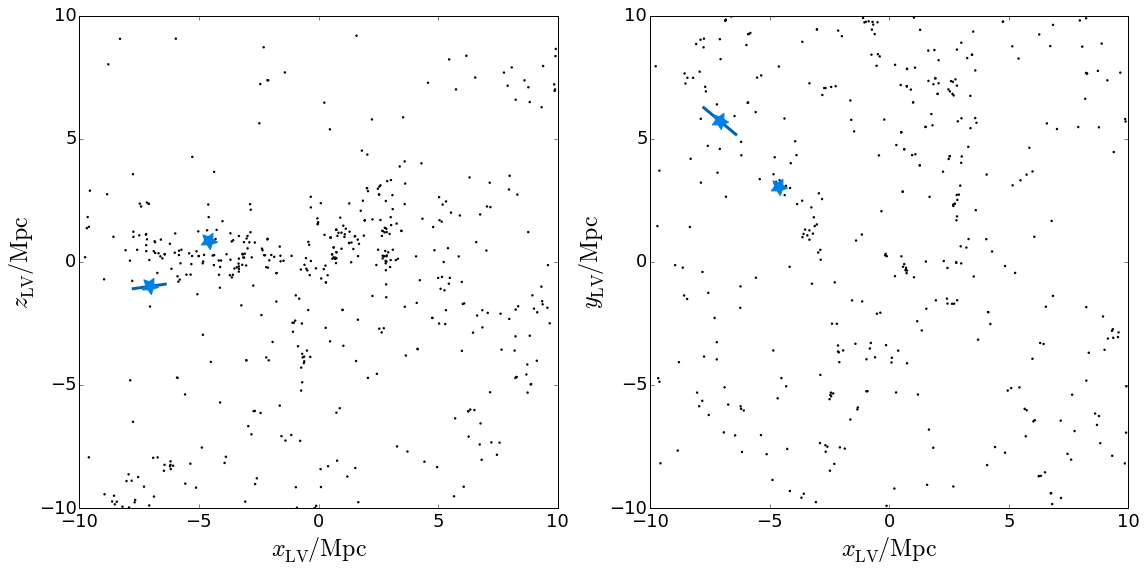

In [39]:
plt.figure(figsize=(16,8))
labelfontsz = 24
tickfontsz = 18
ptscolor = 'k'
pisccolor = (0.,0.5,0.9)
piscunccolor = (0.,0.4,0.7)

plt.subplot(1,2,1)
plt.scatter(xlv[mlgcomplmsk], zlv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter([xA[0], xB[0]], [zA[0], zB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2)
plt.plot([xA[1], xA[2]], [zA[1], zA[2]], color=piscunccolor, lw=3, zorder=1)
plt.plot([xB[1], xB[2]], [zB[1], zB[2]], color=piscunccolor, lw=3, zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$z_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.subplot(1,2,2)
plt.scatter(xlv[mlgcomplmsk], ylv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter([xA[0], xB[0]], [yA[0], yB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2)
plt.plot([xA[1], xA[2]], [yA[1], yA[2]], color=piscunccolor, lw=3, zorder=1)
plt.plot([xB[1], xB[2]], [yB[1], yB[2]], color=piscunccolor, lw=3, zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$y_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.tight_layout()
save_pub_figure('spaceplot')

<IPython.core.display.Javascript object>


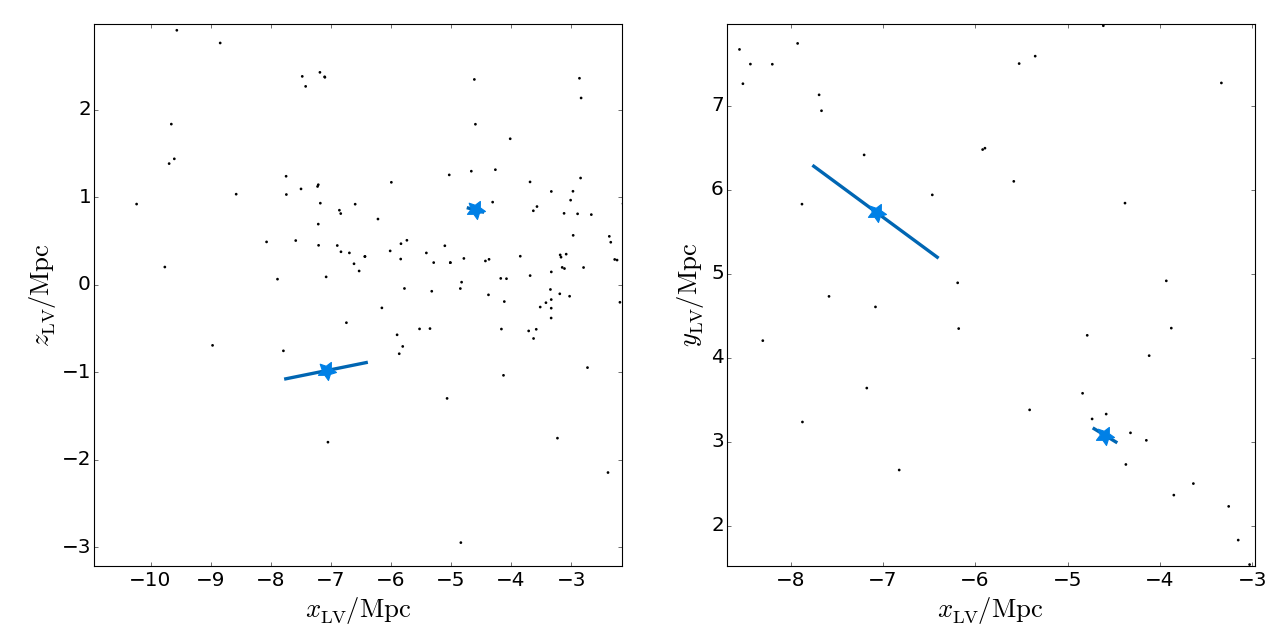

In [42]:
%matplotlib notebook
plt.figure(figsize=(16,8))
labelfontsz = 24
tickfontsz = 18
ptscolor = 'k'
pisccolor = (0.,0.5,0.9)
piscunccolor = (0.,0.4,0.7)

plt.subplot(1,2,1)
plt.scatter(xlv[mlgcomplmsk], zlv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter([xA[0], xB[0]], [zA[0], zB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2)
plt.plot([xA[1], xA[2]], [zA[1], zA[2]], color=piscunccolor, lw=3, zorder=1)
plt.plot([xB[1], xB[2]], [zB[1], zB[2]], color=piscunccolor, lw=3, zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$z_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.subplot(1,2,2)
plt.scatter(xlv[mlgcomplmsk], ylv[mlgcomplmsk], edgecolor='none', s=6, facecolor=ptscolor)
plt.scatter([xA[0], xB[0]], [yA[0], yB[0]], color=pisccolor, marker=(5, 1, 45), s=300, zorder=2)
plt.plot([xA[1], xA[2]], [yA[1], yA[2]], color=piscunccolor, lw=3, zorder=1)
plt.plot([xB[1], xB[2]], [yB[1], yB[2]], color=piscunccolor, lw=3, zorder=1)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xticks(fontsize=tickfontsz)
plt.yticks(fontsize=tickfontsz)
plt.xlabel(r'$x_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)
plt.ylabel(r'$y_{\rm LV}/{\rm Mpc}$', fontsize=labelfontsz)

plt.tight_layout()

## Velocities 

In [ ]:
#vhelio to CMB: http://ned.ipac.caltech.edu/help/velc_help.html
lapex = 264.14*u.deg
bapex = 48.26*u.deg
vapex = 371.0*u.km/u.s

In [149]:
#vhelio to LG: http://ned.ipac.caltech.edu/help/velc_help.html
lapex = 93*u.deg
bapex = -4*u.deg
vapex = 316*u.km/u.s

In [ ]:
#vhelio to vgsr: http://ned.ipac.caltech.edu/help/velc_help.html
lapex = 87.8*u.deg
bapex = 1.7*u.deg
vapex = 232.3*u.km/u.s

In [150]:
apexterm = np.sin(mlsc.galactic.b)*np.sin(bapex) + np.cos(mlsc.galactic.b)*np.cos(bapex)*np.cos(mlsc.galactic.l - lapex)
vgsr = u.Quantity(mml['vhelio'], u.km/u.s) + vapex * apexterm

In [151]:
#remove hubble flow
vnohflow = vgsr - u.Quantity(mml['distance'], u.Mpc)*WMAP9.H0

In [152]:
vxc = vnohflow * mlgcart.x / u.Quantity(mml['distance'], u.Mpc)
vyc = vnohflow * mlgcart.y / u.Quantity(mml['distance'], u.Mpc)
vzc = vnohflow * mlgcart.z / u.Quantity(mml['distance'], u.Mpc)

In [157]:
vhA = 236*u.km/u.s
vhB = 615*u.km/u.s

apexA = np.sin(PiscA.galactic.b)*np.sin(bapex) + np.cos(PiscA.galactic.b)*np.cos(bapex)*np.cos(PiscA.galactic.l - lapex)
vnohgsrA = vhA + vapex * apexA  - PiscA.distance*WMAP9.H0
vxcA = vnohgsrA * PiscA.galactic.cartesian.x / PiscA.distance
vycA = vnohgsrA * PiscA.galactic.cartesian.y / PiscA.distance
vzcA = vnohgsrA * PiscA.galactic.cartesian.z / PiscA.distance

apexB = np.sin(PiscB.galactic.b)*np.sin(bapex) + np.cos(PiscB.galactic.b)*np.cos(bapex)*np.cos(PiscB.galactic.l - lapex)
vnohgsrB = vhB + vapex * apexB  - PiscB.distance*WMAP9.H0
vxcB = vnohgsrB * PiscB.galactic.cartesian.x / PiscB.distance
vycB = vnohgsrB * PiscB.galactic.cartesian.y / PiscB.distance
vzcB = vnohgsrB * PiscB.galactic.cartesian.z / PiscB.distance

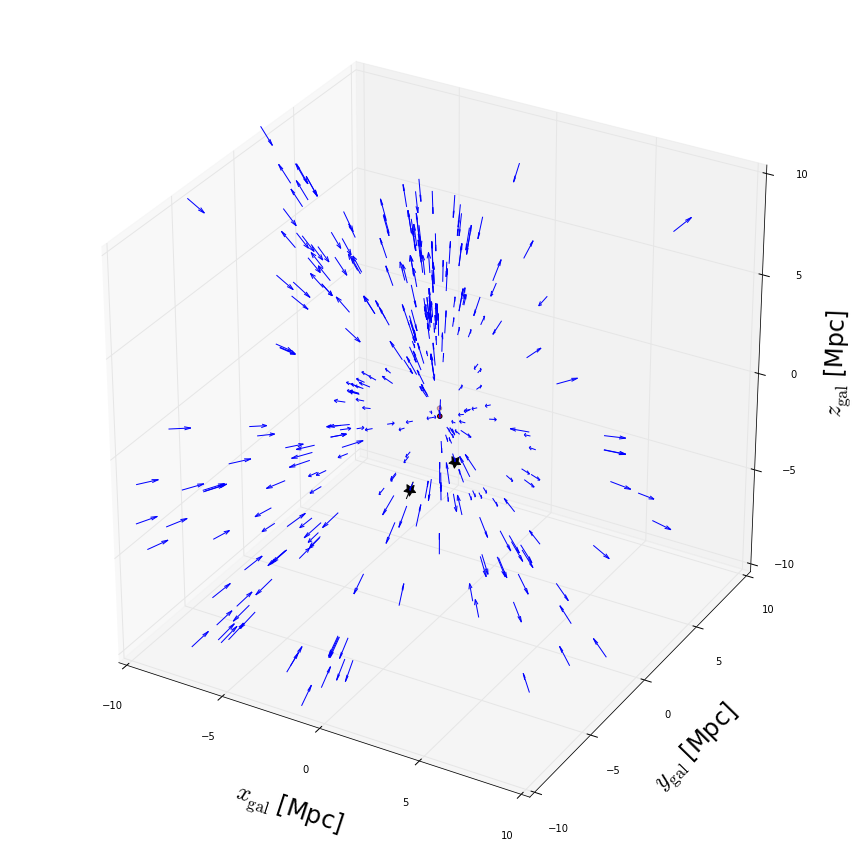

In [158]:
fig = plt.figure(figsize=(12,12))
fig.patch.set_alpha(1)
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0,bottom=0,top=1,right=1, wspace=0, hspace=0)

msk10box = (-10<mlgcart.x.value)&(mlgcart.x.value<10)&(-10<mlgcart.y.value)&(mlgcart.y.value<10)&(-10<mlgcart.z.value)&(mlgcart.z.value<10)
msk = msk10box&mlgcomplmsk


ax.scatter3D(PiscA.galactic.cartesian.x[:1], PiscA.galactic.cartesian.y[:1], PiscA.galactic.cartesian.z[:1], color='k', marker=(5, 1, 30), s=150)
ax.plot3D(PiscA.galactic.cartesian.x[1:], PiscA.galactic.cartesian.y[1:], PiscA.galactic.cartesian.z[1:], color='k')
ax.scatter3D(PiscB.galactic.cartesian.x[:1], PiscB.galactic.cartesian.y[:1], PiscB.galactic.cartesian.z[:1], color='k', marker=(5, 1, 30), s=150)
ax.plot3D(PiscB.galactic.cartesian.x[1:], PiscB.galactic.cartesian.y[1:], PiscB.galactic.cartesian.z[1:], color='k')


ax.scatter3D([m31.galactic.cartesian.x.to(u.Mpc).value, 0], [m31.galactic.cartesian.y.to(u.Mpc).value, 0],c='r')

#extract 6D and then add piscs
x = list(mlgcart.x[msk].value)
y = list(mlgcart.y[msk].value)
z = list(mlgcart.z[msk].value)
vx = list(vxc[msk].value)
vy = list(vyc[msk].value)
vz = list(vzc[msk].value)

x.append(PiscA.galactic.cartesian.x.value[0])
y.append(PiscA.galactic.cartesian.y.value[0])
z.append(PiscA.galactic.cartesian.z.value[0])
vx.append(vxcA.value[0])
vy.append(vycA.value[0])
vz.append(vzcA.value[0])
x.append(PiscB.galactic.cartesian.x.value[0])
y.append(PiscB.galactic.cartesian.y.value[0])
z.append(PiscB.galactic.cartesian.z.value[0])
vx.append(vxcB.value[0])
vy.append(vycB.value[0])
vz.append(vzcB.value[0])



ax.quiver3D(x, y, z, vx, vy, vz)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel(r'$x_{\rm gal}$ [Mpc]', fontsize=24)
ax.set_ylabel(r'$y_{\rm gal}$ [Mpc]', fontsize=24)
ax.set_zlabel(r'$z_{\rm gal}$ [Mpc]', fontsize=24)
plt.tight_layout()

# Calibrated Photometry

In [18]:
from astroquery.irsa_dust import IrsaDust

In [19]:
#Get Dust corrections
ebvmapA = IrsaDust.get_images(PiscA[0], 2*u.degree, 'ebv')[0][0].data
ebvA = ebvmapA[ebvmapA.shape[0]//2, ebvmapA.shape[0]//2]
A606W_A = ebvA*2.471*u.mag # from S & F 11
A814W_A = ebvA*1.526*u.mag # from S & F 11

ebvmapB = IrsaDust.get_images(PiscB[0], 2*u.degree, 'ebv')[0][0].data
ebvB = ebvmapB[ebvmapB.shape[0]//2, ebvmapB.shape[0]//2]
A606W_B = ebvB*2.471*u.mag # from S & F 11
A814W_B = ebvB*1.526*u.mag # from S & F 11

A606W_A, A814W_A, A606W_B, A814W_B

(<Quantity 0.2412872224158658 mag>,
 <Quantity 0.1490102393389766 mag>,
 <Quantity 0.14023352869099867 mag>,
 <Quantity 0.08660314236441277 mag>)

In [20]:
# zero points for calibration of photometry
#same for 2014-11-08 and 2014-10-30
zeroptinfo="""
FILTER  	  PHOTPLAM  	  PHOTFLAM  	  STmag  	  VEGAmag 	  ABmag

F606W
5921.8
7.844e-20
26.664
26.407
26.493

F814W
8059.3
7.007e-20
26.786
25.523
25.947
"""
f606wzpt = 26.407*u.mag
f814wzpt = 25.523*u.mag

In [21]:
#calibrated app mags
PiscA_606 = f606wzpt - 2.5*np.log10(get_struc_param('606A', 'flux'))*u.mag
PiscA_814 = f814wzpt - 2.5*np.log10(get_struc_param('814A', 'flux'))*u.mag

PiscB_606 = f606wzpt - 2.5*np.log10(get_struc_param('606B', 'flux'))*u.mag
PiscB_814 = f814wzpt - 2.5*np.log10(get_struc_param('814B', 'flux'))*u.mag

In [22]:
#need to get matching numbers of distance and appmag chains
# then get the distance modulus and do the extinction correction
minchains = min(PiscA_606.size, PiscA_dist.ravel().size)
PiscA_M606 = PiscA_606[:minchains] - PiscA_dist.distmod.ravel()[:minchains] - A606W_A
PiscA_M814 = PiscA_814[:minchains] - PiscA_dist.distmod.ravel()[:minchains] - A814W_A

minchains = min(PiscB_606.size, PiscB_dist.ravel().size)
PiscB_M606 = PiscB_606[:minchains] - PiscB_dist.distmod.ravel()[:minchains] - A606W_B
PiscB_M814 = PiscB_814[:minchains] - PiscB_dist.distmod.ravel()[:minchains] - A814W_B

In [23]:
#now do photometric transforms
def F606W_F814W_to_VI(f606w, f814w):
    #Sirianni table is from imag, so remove the zpt
    i606 = f606w-f606wzpt
    i814 = f814w-f814wzpt
    
    c0V = 26.325
    c1V = 0.236
    c0I = 25.495
    c1I = -0.002
    #get VmI first b/c that's how the silly table does it
    
    VmI = (i606-i814+(c0V-c0I)*u.mag)/(1-(c1V-c1I))
    V = i606 + c0V*u.mag + c1V*VmI
    I = i814 + c0I*u.mag + c1I*VmI
    
    return V, I

V, I = F606W_F814W_to_VI(PiscA_M606, PiscA_M814)
PiscA_MV = V
PiscA_VmI0 = V-I

V, I = F606W_F814W_to_VI(PiscB_M606, PiscB_M814)
PiscB_MV = V
PiscB_VmI0 = V-I

In [24]:
#match chains of structural parameters
drz_platescale = 0.03*u.arcsec #per pixel

PiscA_reff_sky = get_struc_param('606A', 'reffmaj')*get_struc_param('606A', 'ellipticity')**0.5*drz_platescale
minchains = min(PiscA_reff_sky.size, PiscA_dist.ravel().size)
PiscA_reff = PiscA_reff_sky[:minchains].to(u.radian).value*PiscA_dist.ravel()[:minchains].to(u.pc)

PiscB_reff_sky = get_struc_param('606B', 'reffmaj')*get_struc_param('606B', 'ellipticity')**0.5*drz_platescale
minchains = min(PiscB_reff_sky.size, PiscB_dist.ravel().size)
PiscB_reff = PiscB_reff_sky[:minchains].to(u.radian).value*PiscB_dist.ravel()[:minchains].to(u.pc)

In [25]:
#use distance chains to get MHI-chains assuming gaussian errors
PiscA_MHIwerr = PiscA_MHI[0] + PiscA_MHI[1]*np.random.randn(PiscA_dist.size)
PiscA_MHIwdist = PiscA_MHIwerr * PiscA_dist.ravel()**2

PiscB_MHIwerr = PiscB_MHI[0] + PiscB_MHI[1]*np.random.randn(PiscB_dist.size)
PiscB_MHIwdist = PiscB_MHIwerr * PiscB_dist.ravel()**2

In [26]:
#work out PA from pixel coordinates to WCS
wcsA = WCS(fits.getheader('drizzled_PiscA_F606W_err/PiscA_F606W_err_drc_sci.fits'))
theta_to_pa_A = np.arctan2(*wcsA.pixel_scale_matrix[0])*u.rad

PiscA_PA = get_struc_param('606A', 'theta')*u.deg + theta_to_pa_A


wcsB = WCS(fits.getheader('drizzled_PiscB_F606W_err/PiscB_F606W_err_drc_sci.fits'))
theta_to_pa_B = np.arctan2(*wcsB.pixel_scale_matrix[0])*u.rad

PiscB_PA = get_struc_param('606B', 'theta')*u.deg + theta_to_pa_B

In [27]:
#summary statistics for table
def q_to_pmstr(q, percentile=.16):
    lp = percentile*100
    up = 100 - percentile*100
    m, l, u = np.percentile(q, [50, lp, up])
    return '{0.value[0]} +{0.value[1]} -{0.value[2]} {0.unit}'.format([m, m-l, u-m]*q.unit)
    

print('PiscA_M606', q_to_pmstr(PiscA_M606))
print('PiscA_M814', q_to_pmstr(PiscA_M814))
print('PiscA_606-814', q_to_pmstr(PiscA_M606-PiscA_M814))
print('PiscA_MV', q_to_pmstr(PiscA_MV))
print('PiscA_VmI0', q_to_pmstr(PiscA_VmI0))
print('PiscA_PA', q_to_pmstr(PiscA_PA))
print('PiscA_reff', q_to_pmstr(PiscA_reff))
print('PiscA_MHIwdist', q_to_pmstr(PiscA_MHIwdist.to(u.solMass*1e5)))

print('')

print('PiscB_M606', q_to_pmstr(PiscB_M606))
print('PiscB_M814', q_to_pmstr(PiscB_M814))
print('PiscB_606-814', q_to_pmstr(PiscB_M606-PiscB_M814))
print('PiscB_MV', q_to_pmstr(PiscB_MV))
print('PiscB_VmI0', q_to_pmstr(PiscB_VmI0))
print('PiscB_PA', q_to_pmstr(PiscB_PA))
print('PiscB_reff', q_to_pmstr(PiscB_reff))
print('PiscB_MHIwdist', q_to_pmstr(PiscB_MHIwdist.to(u.solMass*1e5)))

PiscA_M606 -11.6509112049 +0.0571455204703 -0.0551924893073 mag
PiscA_M814 -12.2961654426 +0.057051186668 -0.0555642432922 mag
PiscA_606-814 0.645414975384 +0.00968915036672 -0.00953448637818 mag
PiscA_MV -11.5499143176 +0.0574242317583 -0.0555180089887 mag
PiscA_VmI0 0.776135138299 +0.0127154204288 -0.0125124493152 mag
PiscA_PA 136.441399277 +1.2605691604 -1.26905164743 deg
PiscA_reff 143.81129291 +5.05537796773 -5.14475718069 pc
PiscA_MHIwdist 87.4653940622 +7.49576440687 -8.07132183622 100000 solMass

PiscB_M606 -12.9759932939 +0.207305893966 -0.20689895542 mag
PiscB_M814 -13.4609542426 +0.207911977352 -0.206798406268 mag
PiscB_606-814 0.484624976571 +0.00555775385348 -0.00552064729323 mag
PiscB_MV -12.9244361115 +0.207158925089 -0.206398518225 mag
PiscB_VmI0 0.565124641169 +0.00729364022766 -0.00724494395437 mag
PiscB_PA 139.094596373 +0.0841880512458 -0.0866798878861 deg
PiscB_reff 331.126304572 +30.1018041643 -33.062063813 pc
PiscB_MHIwdist 316.072722964 +63.5247218356 -73.669410

# Scaling Relations 

In [8]:
%matplotlib inline

In [13]:
#import data for LG

import nearbygals

ngtab = nearbygals.get_table('/Users/erik/astrodata/mcconn12_nearbydwarfs/NearbyGalaxies.dat', dropmw=False)

mw = SkyCoord(l=0*u.deg,b=0*u.deg, distance=8.5*u.kpc, frame='galactic').icrs
m31 = ngtab[ngtab['name']=='Andromeda']['center'][0]

m31d = np.array([m31.separation_3d(c).kpc for c in ngtab['center']])
mwd = np.array([mw.separation_3d(c).kpc for c in ngtab['center']])
mwd[0] = 0 #The MW itself
m31closer = m31d < mwd

ds = ngtab['distance'].copy()
vhs = ngtab['vh']
vabs = ngtab['Vabs']
ds[m31closer] = m31d[m31closer]
ds[~m31closer] = mwd[~m31closer]

sfingdct = {'And XXX': False,
 'And XXXI': False,
 'And XXXII': False,
 'Andromeda': True,
 'Andromeda I': False,
 'Andromeda II': False,
 'Andromeda III': False,
 'Andromeda IX': False,
 'Andromeda V': False,
 'Andromeda VI': False,
 'Andromeda VII': False,
 'Andromeda X': False,
 'Andromeda XI': False,
 'Andromeda XII': False,
 'Andromeda XIII': False,
 'Andromeda XIV': False,
 'Andromeda XIX': False,
 'Andromeda XV': False,
 'Andromeda XVI': False,
 'Andromeda XVII': False,
 'Andromeda XVIII': False,
 'Andromeda XX': False,
 'Andromeda XXI': False,
 'Andromeda XXII': False,
 'Andromeda XXIII': False,
 'Andromeda XXIV': False,
 'Andromeda XXIX': False,
 'Andromeda XXV': False,
 'Andromeda XXVI': False,
 'Andromeda XXVII': False,
 'Andromeda XXVIII': False,
 'Antlia': True,
 'Aquarius': True,
 'Bootes (I)': False,
 'Bootes II': False,
 'Bootes III': False,
 'Canes Venatici (I)': False,
 'Canes Venatici II': False,
 'Canis Major': False,
 'Carina': False,
 'Cetus': False,
 'Coma Berenices': False,
 'DDO 113': True,
 'DDO 125': True,
 'DDO 190': True,
 'DDO 99': True,
 'Draco': False,
 'ESO 294- G 010': False,
 'ESO 410- G 005': False,
 'Fornax': False,
 'GR 8': True,
 'HIZSS 3(A)': True,
 'HIZSS 3B': True,
 'Hercules': False,
 'IC 10': True,
 'IC 1613': True,
 'IC 3104': True,
 'IC 4662': True,
 'IC 5152': True,
 'KKH 86': True,
 'KKH 98': True,
 'KKR 25': False,
 'KKR 3': True,
 'LGS 3': True,
 'LMC': True,
 'Leo A': True,
 'Leo I': False,
 'Leo II': False,
 'Leo IV': False,
 'Leo P': True,
 'Leo T': True,
 'Leo V': False,
 'M32': False,
 'NGC 147': False,
 'NGC 185': False,
 'NGC 205': False,
 'NGC 300': True,
 'NGC 3109': True,
 'NGC 4163': True,
 'NGC 55': True,
 'NGC 6822': True,
 'Pegasus dIrr': True,
 'Phoenix': True,
 'Pisces II': False,
 'SMC': True,
 'Sagittarius dIrr': True,
 'Sagittarius dSph': False,
 'Sculptor': False,
 'Segue (I)': False,
 'Segue II': False,
 'Sextans (I)': False,
 'Sextans A': True,
 'Sextans B': True,
 'The Galaxy': True,
 'Triangulum': True,
 'Tucana': False,
 'UGC 4879': True,
 'UGC 8508': True,
 'UGC 9128': True,
 'UGCA 86': True,
 'UKS 2323-326': True,
 'Ursa Major (I)': False,
 'Ursa Major II': False,
 'Ursa Minor': False,
 'WLM': True,
 'Willman 1': False}
sfing = np.array([sfingdct[nm] for nm in ngtab['name']])


mw = SkyCoord(l=0*u.deg,b=0*u.deg, distance=8.5*u.kpc, frame='galactic').icrs
m31 = ngtab[ngtab['name']=='Andromeda']['center'][0]

m31d = np.array([m31.separation_3d(c).kpc for c in ngtab['center']])
mwd = np.array([mw.separation_3d(c).kpc for c in ngtab['center']])
mwd[0] = 0 #The MW itself
m31closer = m31d < mwd

ds = ngtab['distance'].copy()
vhs = ngtab['vh']
vabs = ngtab['Vabs']
ds[m31closer] = m31d[m31closer]
ds[~m31closer] = mwd[~m31closer]

Rh = u.Quantity(ngtab['rh'], u.arcmin)
dlos = u.Quantity(ngtab['distance'])
Reff = Rh.to(u.radian).value*dlos

mag2lmstar = lambda mag, mag_sun=4.65, mtol=1: (mag - mag_sun)/-2.5 + np.log10(mtol)

mhing = u.Quantity(ngtab['MHI'], u.solMass)
lmhing = np.log10(mhing/u.solMass).value

lMstarng = np.array(mag2lmstar(ngtab['Vmag'] - ngtab['distmod'], 4.83, 1))

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:151: RuntimeWarning: divide by zero encountered in log10


In [34]:
# import data for leop

leopmstar=5.7e5 * u.solMass
leopmhi=9.3e5 * u.solMass
leopdist=1.72*u.Mpc
leopMV=-9.41*u.mag
leopRelim=0.58*u.kpc  #that's the "Semimajor axis", which isn't really Re
leopRe=.188*u.kpc #from below

In [37]:
## import data for SHIELD galaxies from Cannon+ 11
shieldtabstr="""
Table 1
VLA/EVLA Observations of ALFALFA-selected Low-mass Dwarf Galaxies

AGC^a	alpha	delta	Distance	M_r	(u - r)	M_B	(B - V)	%Z_sun^b	V_21	W_21	log (M_H i)	
	(J2000)	(J2000)	(Mpc)	(mag)	(mag)	(mag)	(mag)		(km s^-1)	(km s^-1)	(M_sun)	
Concept demonstration targets	
100062	00:09:52.8	15:43:58	12.7^c	-15.02	1.02 +or- 0.02	N/A	N/A	N/A	869	45	7.82	
101772	00:11:08.2	14:14:08	11.7^c	-13.64	0.98 +or- 0.06	N/A	N/A	N/A	802	37	7.54	
111945	01:44:42.7	27:17:18	6.3^c	-11.88^d	3.35 +or- 1.26^d	N/A	N/A	N/A	420	38	7.28	
321203	22:13:03.3	28:04:28	16.4^c	-14.20	0.98 +or- 0.04	N/A	N/A	14%	983	62	7.83	
321307	22:14:04.4	25:41:08	18.7^c	-13.88	1.24 +or- 0.07	N/A	N/A	N/A	1152	60	7.96	
332939	23:08:16.0	31:53:57	11.4^c	-13.67	0.69 +or- 0.05	N/A	N/A	N/A	692	41	7.74	
	
The SHIELD sample	
748778^e	00:06:34.3	15:30:39	5.4^c	-10.52	0.81 +or- 0.19	-10.02	0.25 +or- 0.03	N/A	258	16	6.51	
112521^e	01:41:07.6	27:19:24	7.2^f	-11.52^d	2.19 +or- 0.42^d	-10.80	0.45 +or- 0.03	6%	274	26	6.92	
110482^e	01:42:17.4	26:22:00	7.2^f	-13.63	1.25 +or- 0.04	-12.86	0.49 +or- 0.02	13%	357	30	7.21	
111946^e	01:46:42.2	26:48:05	7.2^f	-11.49^d	1.46 +or- 0.25^d	-11.48	0.39 +or- 0.03	5%	367	21	6.97	
111977^e	01:55:20.2	27:57:14	5.5^g	-12.55^d	2.26 +or- 0.16^d	-12.31	0.47 +or- 0.02	N/A	207	26	6.78	
111164^e	02:00:10.1	28:49:52	4.9^g	-11.50^d	0.80 +or- 0.09^d	-11.10	0.41 +or- 0.02	N/A	163	27	6.57	
174585^h,^i	07:36:10.3	09:59:11	6.1^c	N/A	N/A	N/A	N/A	N/A	356	21	6.68	
174605^h	07:50:21.7	07:47:40	6.0^c	-10.46^d	1.85 +or- 0.21^d	-10.98	0.47 +or- 0.05	N/A	351	24	6.75	
182595^h	08:51:12.1	27:52:48	6.1^c	-12.45	1.27 +or- 0.05	-11.75	0.52 +or- 0.05	N/A	398	20	6.66	
731457^h	10:31:55.8	28:01:33	5.4^c	-12.55	1.23 +or- 0.03	-12.02	0.39 +or- 0.05	N/A	454	36	6.63	
749237^h	12:26:23.4	27:44:44	3.2^c	-11.58	1.28 +or- 0.03	-11.21	0.44 +or- 0.05	N/A	372	65	6.64	
749241^h	12:40:01.7	26:19:19	4.3^c	-9.27	0.83 +or- 0.15	-9.57	0.22 +or- 0.05	N/A	451	18	6.52	

Notes.
a Arecibo General Catalog.
b Assuming the solar oxygen abundance from Asplund et al. (2009).
c Derived using the parametric multiattractor flow model developed by Masters (2005); see further discussion in Martin et al. (2010).
d Magnitudes and colors uncertain due to SDSS shredding issues.
e WIYN 3.5 m imaging acquired in Fall 2010.
f Probable member of NGC 672 group.
g Tip of the red giant branch.
h WIYN 3.5 m imaging acquired in Spring 2011.
i AGC 174585 is outside the SDSS footprint; an absolute calibration of the WIYN 3.5 m observations awaits subsequent re-imaging.
"""[1:-1]

indat = False
shinum = []
shiMr = []
shilMHI = []
shiw50 = []
for ln in shieldtabstr.split('\n'):
    if ln.startswith('Concept demonstration targets') or ln.startswith('The SHIELD sample'):
        indat = True
    elif indat:
        if ln.strip() == '':
            indat = False
        else:
            lns = ln.strip().split('\t')
            if lns[4] != 'N/A':
                shinum.append(int(lns[0].split('^')[0]))
                shiMr.append(float(lns[4].split('^')[0]))
                shilMHI.append(float(lns[-1]))
                shiw50.append(float(lns[-2]))

shinum = np.array(shinum)
shiMr = np.array(shiMr)
shilMHI = np.array(shilMHI)
shiw50 = np.array(shiw50)     
shilMstar = mag2lmstar(shiMr)

In [47]:
#combine measyurements from above for piscs
Pisc_MVs_med = u.Quantity([np.median(PiscA_MV), np.median(PiscB_MV)])
Pisc_reffs_med = u.Quantity([np.median(PiscA_reff), np.median(PiscB_reff)])

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:462: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x11c6cffd0> has a label of u'_collection1' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:462: UserWarning: The handle <matplotlib.collections.PolyCollection object at 0x11c84fcd0> has a label of u'_collection3' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


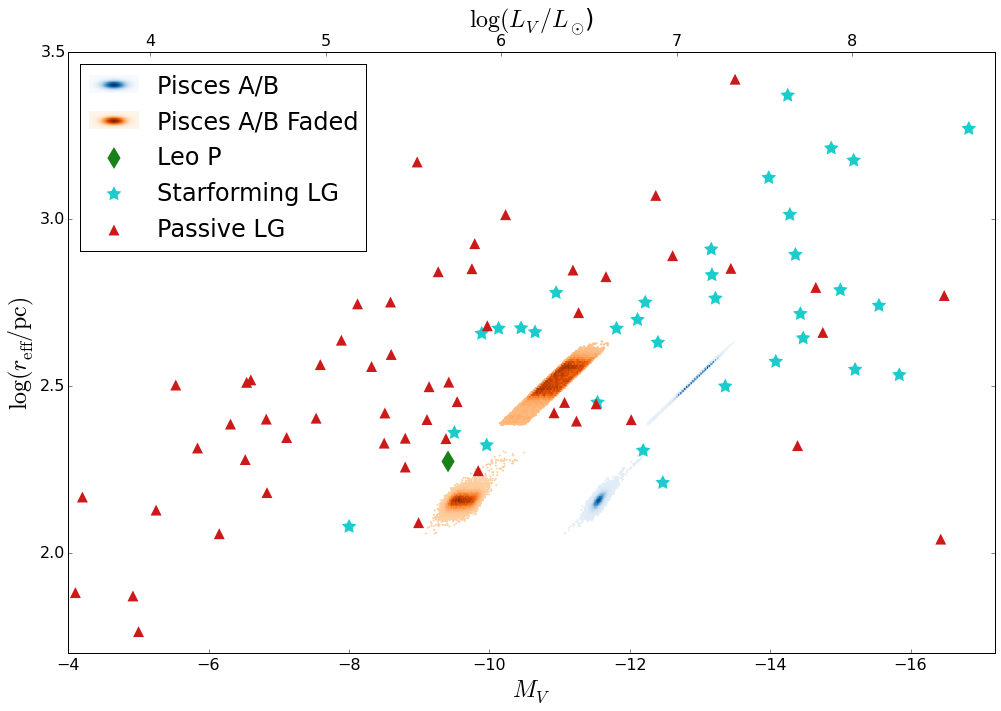

In [554]:
plt.figure(figsize=(14,10))
pointscale = 3.
tcksfontsize = 16
labelfontsize = 24

msk = vabs <-0.5  # there are some failed points at ~0

sfvabs = vabs[msk&sfing]
sfRe = Reff.value[msk&sfing]


#plt.scatter(shiMr, np.log10(Pisc_reffs/u.pc), s=250*pointscale, marker='s', color='k', label='Pisces A/B')


#plt.scatter(Pisc_MVs_med, np.log10(Pisc_reffs_med/u.pc), s=250*pointscale, marker='s', color='k', label='Pisces A/B', zorder=3)
#plt.scatter(M606s+3*u.mag, np.log10(Pisc_reffs/u.pc), s=250*pointscale, marker='s', color='m', label='Pisces A/B (faded)')
hx_handles = []
hexbinkwargs ={'cmap':'Blues','mincnt':1,'vmin':-50}
hx_handles.append(plt.hexbin(PiscA_MV, np.log10(PiscA_reff/u.pc), label='Pisces A/B', gridsize=100, **hexbinkwargs))
hx_handles.append(plt.hexbin(PiscB_MV, np.log10(PiscB_reff/u.pc), gridsize=75, **hexbinkwargs))

Voff = 2.5*np.log10(np.random.rand(len(PiscA_MV))*2+5)*u.mag
hexbinkwargs['cmap'] = 'Oranges'
hx_handles.append(plt.hexbin(PiscA_MV+Voff, np.log10(PiscA_reff/u.pc), label='Pisces A/B Faded', gridsize=100, **hexbinkwargs))
hx_handles.append(plt.hexbin(PiscB_MV+Voff, np.log10(PiscB_reff/u.pc), gridsize=75, **hexbinkwargs))

plt.scatter([leopMV.value], np.log10([leopRe/u.pc]), marker='d', c=(0.1,0.5,0.1), label='Leo P',edgecolor='none',
            s=80*pointscale, zorder=2)


plt.scatter(sfvabs, np.log10(sfRe)+3, lw=1, c=(0.1,0.8,0.8), edgecolor='none', marker=(5, 1, 0), label='Starforming LG', s=80*pointscale, zorder=1)
plt.scatter(vabs[msk&~sfing], np.log10(Reff.value[msk&~sfing])+3, marker='^', edgecolor='none', c=(0.8,0.1,0.1), label='Passive LG', s=40*pointscale, zorder=1)


plt.ylim(1.7, 3.5)
plt.ylabel(r'$\log(r_{\rm eff}/{\rm pc})$',fontsize=labelfontsize)

#now set the limits
maglims = (-4,-17.2)
plt.xlim(*maglims)
plt.xlabel(r'$M_V$',fontsize=labelfontsize)
plt.xticks(fontsize=tcksfontsize)
plt.yticks(fontsize=tcksfontsize)


#now some tricks to get the legend to look decent
from matplotlib.legend import Legend
import matplotlib.collections as mcoll

class HandlerHexbin(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):        
        nx = ny = 50
        sig = 1
        xscale = handlebox.width / sig / 2
        yscale = handlebox.height / sig / 2
        
        xg, yg = np.mgrid[-sig:sig:nx*1j,-sig:sig:nx*1j] + sig
        gvals = np.exp(-(xg*xg+yg*yg)/2)
        offsets = np.array([xscale*xg.ravel(), yscale*yg.ravel()]).T
        
        polygon = np.zeros((4, 2), float)
        polygon[:, 0] =  np.array([0.5, 0.5, -0.5, -0.5])*xscale*sig*2/nx
        polygon[:, 1] =  np.array([-0.5,0.5,0.5,-0.5])*yscale*sig*2/ny
        
        coll = mcoll.PolyCollection([polygon], offsets=offsets.ravel(), 
                            transOffset=mtransforms.IdentityTransform(),
                            offset_position="data", edgecolors='face',
                                   transform=handlebox.get_transform(),
                                   cmap=orig_handle.get_cmap())
        coll.set_array(vals.ravel())
        handlebox.add_artist(coll)
        return pc
    
#plt.legend(loc='upper left', scatterpoints=1, fontsize=labelfontsize)
handles, _ = plt.gca().get_legend_handles_labels()
handler_map = dict([(h.__class__, Legend.get_default_handler_map()[h.__class__]) for h in handles])
handler_map[mcoll.PolyCollection] =  HandlerHexbin()
leg = plt.legend(handles=hx_handles + handles, handler_map=handler_map, 
               loc='upper left', scatterpoints=1, fontsize=labelfontsize,)


#add the L_V axis
plt.twiny()
plt.xlim((maglims[0]-4.83)/-2.5,(maglims[1]-4.83)/-2.5)
plt.xlabel(r'$\log(L_V/L_\odot$)',fontsize=labelfontsize)
plt.xticks(fontsize=tcksfontsize)

plt.tight_layout()
save_pub_figure('context')